In [216]:
import pandas as pan
import numpy as np


In [ ]:
### select strongest cis eqtl ### 
## run the findr 1_select_cis_eqtls.py## 

In [ ]:
#### prepare genotype data #############
# genotype prepared by writing the 2_prepare_genotype_data.py file#### 
### the output is genotypes_binary_strongest_eqtl.csv file ########

In [23]:
## reorder expression data ### 
## run the findr 3_reorder_expression_data.py ### 

# Reorder the gene expression data matrices:
#    Load data:
#    Reordering:


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if (await self.run_code(code, result,  async_=asy)):


       numbers_of_genes:  [2836, 5720, 2884]
       genes with eQTLs:  2884
       all genes:  5720
    Check if all expected columns are present: True
    number of columns selected: 5720


In [2]:
#yeastract= pan.read_csv("./../data/input/yeastract/DNABinding_AND_Expr_TF_act_OR_inh_RegulationMatrix_Documented_2020511.csv.gz",header=0,index_col=0,
                           # delimiter=';')

In [217]:
## read yeastract file ######
yeastract= pan.read_csv("./../data/input/yeastract/DNABinding_AND_Expr_TF_act_OR_inh_RegulationMatrix_Documented_2020511.csv.gz",header=0,index_col=0,
                            delimiter=';')

In [218]:
sum(yeastract.sum())

11486

In [ ]:
#### ensemble file downloaded and preprocessing done using the shell script file ##### 
## ensembl 109 used for yeast ## 

In [ ]:
print('#  Selecting compatible subset of yeast regulatory network from yeastract with respect to elife paper.')
print('#  1. Load ensembl yeast gene library:')

In [219]:
df_full = pan.read_csv( './../data/cleaned_genes_ensembl109_yeast_step1.txt', skiprows=0,
                    names='chromosome position gene_str'.split(), 
                    usecols=[0,3,8],
                    comment='#',
                    sep='\t| ', engine='python')

df_full['id'] = df_full['gene_str'].str.split(':').str[1]
full_gene_list = df_full['id'].to_list()

In [220]:
#   The file used below only contains those entries with Name and ID.
df = pan.read_csv("./../data/cleaned_genes_ensembl109_yeast_step2.txt", skiprows=0,
                    names='chromosome position gene_str name_str'.split(), 
                    usecols=[0,3,8,9],
                    comment='#',
                    sep='\t| ', engine='python')

In [221]:
print('#  data frame as loaded')
print(df)

#  data frame as loaded
     chromosome  position           gene_str   name_str
0             I      1807    ID=gene:YAL068C  Name=PAU8
1             I      7235    ID=gene:YAL067C  Name=SEO1
2             I     13363  ID=gene:YAL064C-A  Name=TDA8
3             I     24000    ID=gene:YAL063C  Name=FLO9
4             I     31567    ID=gene:YAL062W  Name=GDH3
...         ...       ...                ...        ...
5155        XVI    924304    ID=gene:YPR194C  Name=OPT2
5156        XVI    934034    ID=gene:YPR198W  Name=SGE1
5157        XVI    938148    ID=gene:YPR199C  Name=ARR1
5158        XVI    939279    ID=gene:YPR200C  Name=ARR2
5159        XVI    939922    ID=gene:YPR201W  Name=ARR3

[5160 rows x 4 columns]


In [222]:
#   Create new column name and id
df['name'] = df['name_str'].str.split('=').str[1]
df['id'] = df['gene_str'].str.split(':').str[1]
#   Sort it
dfs=df.sort_values(axis=0,by='chromosome position'.split() )
#   Make gene_name_dict
print('#  data frame after column operations and sorting')
print(dfs)
df['name'] = df['name'].str.upper()
df['id'] = df['id'].str.upper()
dfi = dfs.set_index('name')
gene_name_dict = dfi['id'].to_dict()
print('#  number of genes:', len(gene_name_dict))

#  data frame after column operations and sorting
     chromosome  position           gene_str   name_str  name         id
0             I      1807    ID=gene:YAL068C  Name=PAU8  PAU8    YAL068C
1             I      7235    ID=gene:YAL067C  Name=SEO1  SEO1    YAL067C
2             I     13363  ID=gene:YAL064C-A  Name=TDA8  TDA8  YAL064C-A
3             I     24000    ID=gene:YAL063C  Name=FLO9  FLO9    YAL063C
4             I     31567    ID=gene:YAL062W  Name=GDH3  GDH3    YAL062W
...         ...       ...                ...        ...   ...        ...
5155        XVI    924304    ID=gene:YPR194C  Name=OPT2  OPT2    YPR194C
5156        XVI    934034    ID=gene:YPR198W  Name=SGE1  SGE1    YPR198W
5157        XVI    938148    ID=gene:YPR199C  Name=ARR1  ARR1    YPR199C
5158        XVI    939279    ID=gene:YPR200C  Name=ARR2  ARR2    YPR200C
5159        XVI    939922    ID=gene:YPR201W  Name=ARR3  ARR3    YPR201W

[5160 rows x 6 columns]
#  number of genes: 5160


In [223]:
compatible_yeastract  =  relabel_matrix(  yeastract, gene_name_dict, full_gene_list )

old_cols, n= 3912
Index(['PAU8', 'SEO1', 'YAL064W-B', 'TDA8', 'YAL064W', 'FLO9', 'NHP6B',
       'YBR090C', 'TIM12', 'PHO3',
       ...
       'YBR012W-B', 'YDR210C-D', 'YGR161W-C', 'YHR214C-B', 'YPR158W-B',
       'MAL61', 'MAL62', 'Uncharacterized.167', 'YDR524W-C', 'MAL63'],
      dtype='object', length=3912)
old_rows, n= 152
['Smp1p' 'Ert1p' 'Thi2p' 'Mal33p' 'Kar4p' 'Hcm1p' 'Tup1p' 'Rds1p' 'Uga3p'
 'Pho2p' 'Mbp1p' 'Rpn4p' 'Nrg1p' 'Pdc2p' 'Ino2p' 'Swi5p' 'Ume6p' 'Upc2p'
 'Adr1p' 'Met32p' 'Yap6p' 'Sum1p' 'Aro80p' 'Cad1p' 'Yhp1p' 'Stp1p' 'Urc2p'
 'Gcn4p' 'Mig3p' 'Gln3p' 'Aca1p' 'Flo8p' 'Swi4p' 'Rph1p' 'Tog1p' 'Hac1p'
 'Gat1p' 'Pho4p' 'Fzf1p' 'Rtg2p' 'Hap2p' 'Mig2p' 'Cup2p' 'Tos8p' 'Hsf1p'
 'Aft1p' 'Mig1p' 'Pdr1p' 'Rme1p' 'Mga1p' 'Rim101p' 'Opi1p' 'Yap3p' 'Stp2p'
 'Ste12p' 'Ndt80p' 'Stb5p' 'Skn7p' 'Fkh1p' 'Xbp1p' 'Cst6p' 'Met28p'
 'Yap5p' 'Dal81p' 'Mga2p' 'YJL206C' 'Gzf3p' 'Cbf1p' 'Ime1p' 'Rsf2p'
 'Hms2p' 'Ash1p' 'Abf1p' 'Hap4p' 'Msn4p' 'Phd1p' 'Rgt1p' 'Ixr1p' 'Spt23p'
 'Put3p' 'Dal80p

In [224]:
compatible_yeastract

,YAL068C,YAL067C,YAL064W-B,YAL064C-A,YAL064W,YAL063C,YBR089C-A,YBR090C,YBR091C,YBR092C,...,YPR036W-A,YPR158W-A,YBR012W-A,YHR047C,YBR012W-B,YDR210C-D,YGR161W-C,YHR214C-B,YPR158W-B,YDR524W-C
3912,,,,,,,,,,,,,,,,,,,,,
YBR182C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
YBR239C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
YBR240C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
YBR297W,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
YCL055W,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YBL005W,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
YBR049C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
YBR083W,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0


In [196]:
type(compatible_yeastract)

pandas.core.frame.DataFrame

In [225]:
### remove columns whose names are not there in the expression matrix ######### 
expression_genes=pan.read_csv('list_genes_in_order_01.csv',header=None)[0].to_list()

In [226]:
expression_genes

['YAL027W',
 'YAL019W',
 'YAL022C',
 'YAL011W',
 'YAL013W',
 'YAL009W',
 'YAL003W',
 'YAL010C',
 'YAL008W',
 'YAL012W',
 'YAR002C-A',
 'YAR002W',
 'YAR008W',
 'YAR003W',
 'YAR010C',
 'YAR009C',
 'YAR015W',
 'YAR018C',
 'YAR019C',
 'YAR020C',
 'YAR023C',
 'YAR029W',
 'YAR035W',
 'YAR042W',
 'YAR050W',
 'YAL062W',
 'YAL060W',
 'YAL056W',
 'YAL055W',
 'YAL054C',
 'YAL049C',
 'YAL047C',
 'YAL042W',
 'YAL038W',
 'YAL044C',
 'YAL039C',
 'YAL040C',
 'YAL033W',
 'YAL032C',
 'YAL029C',
 'YAL020C',
 'YAL028W',
 'YBL049W',
 'YBL035C',
 'YBL051C',
 'YBL052C',
 'YBL039C',
 'YBL040C',
 'YBL047C',
 'YBL044W',
 'YBL043W',
 'YBL041W',
 'YBL039W-B',
 'YBL038W',
 'YBL036C',
 'YBL033C',
 'YBL030C',
 'YBL029C-A',
 'YBL025W',
 'YBL029W',
 'YBL028C',
 'YBL010C',
 'YBL024W',
 'YBL020W',
 'YBL019W',
 'YBL018C',
 'YBL105C',
 'YBL017C',
 'YBL016W',
 'YBL015W',
 'YBL011W',
 'YBL014C',
 'YBL007C',
 'YBL006C',
 'YBL005W',
 'YBR001C',
 'YBL008W',
 'YBL106C',
 'YBR007C',
 'YBR003W',
 'YBR008C',
 'YBR013C',
 'YBR014C'

In [227]:
commoncolumns= [item for item in expression_genes if item in compatible_yeastract.columns]

In [228]:
commonrows=[item for item in expression_genes if item in compatible_yeastract.index]

In [229]:
len(commonrows)

148

In [230]:
compatible_yeastract= compatible_yeastract.loc[commonrows,commoncolumns]

In [231]:
compatible_yeastract.index

Index(['YBL005W', 'YBR083W', 'YBR239C', 'YCR065W', 'YCR084C', 'YDR310C',
       'YDR421W', 'YDR423C', 'YDR253C', 'YDL170W',
       ...
       'YFL031W', 'YPR199C', 'YAL051W', 'YOR230W', 'YGR249W', 'YJR147W',
       'YBR182C', 'YOR372C', 'YIL036W', 'YMR037C'],
      dtype='object', name='3912', length=148)

In [232]:
df=pan.read_csv('./strongest_eqtls_r_3columns.csv')

In [159]:
df

,r_abs,gene,pmarker,r
0,33,YAL003W,chrI:133174_G/A,0.383781
1,31,YAL008W,chrI:136961_T/C,0.273774
2,30,YAL009W,chrI:132723_G/A,-0.260297
3,29,YAL010C,chrI:134219_C/T,0.196381
4,28,YAL011W,chrI:131539_C/T,-0.302313
...,...,...,...,...
2879,36410,YPR180W,chrXVI:897736_G/A,0.229310
2880,36411,YPR186C,chrXVI:907815_T/C,0.131461
2881,36412,YPR191W,chrXVI:921485_T/C,0.146219
2882,36413,YPR192W,chrXVI:922297_T/C,0.790686


In [233]:
df.drop(columns=df.columns[0], axis=1,  inplace=True)

In [234]:
df.columns=['cis','pmarker','r']

In [235]:
eqtlgenes=df['cis']

In [236]:
yeastractgenes=compatible_yeastract.index

In [237]:
len(set(eqtlgenes).intersection(set(yeastractgenes)))  ## the number of trios that we can take is 80*3671 # 80 of the TFs are cis eQTLs

80

In [238]:
len(set(eqtlgenes).intersection(set(compatible_yeastract.columns))) ## 1710 out of the total 3671 columns genes are cis eQTLs 

1710

In [239]:
len(set(yeastractgenes).intersection(set(compatible_yeastract.columns))) ## 125 TFs are both rows and columns, should we remove self regulation ?

123

In [240]:
commontfs = [item for item in eqtlgenes if item in yeastractgenes] # not using set, because reproducing the result is not possible

In [241]:
subset_yeast=compatible_yeastract.loc[commontfs,]

In [242]:
subset_mod = subset_yeast.loc[:, (subset_yeast != 0).any(axis=0)]

In [243]:
subset_mod

,YAL019W,YAL022C,YAL013W,YAL003W,YAL012W,YAR002W,YAR003W,YAR010C,YAR009C,YAR015W,...,YOR372C,YLR075W,YOR299W,YPL279C,YDR343C,YER072W,YER158C,YBL032W,YMR037C,YPL247C
3912,,,,,,,,,,,,,,,,,,,,,
YBL005W,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
YBR083W,0,0,0,0,0,0,0,1,0,1,...,0,0,1,0,1,0,1,0,1,0
YBR239C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
YCR065W,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
YCR084C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YOR363C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
YPL038W,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
YPL133C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [491]:
sum(subset_yeast.sum())

5710

In [245]:
sum((subset_yeast==0).sum())

268050

In [299]:
5710+268050

273760

In [250]:
subset_yeast

,YAL019W,YAL022C,YAL013W,YAL003W,YAL012W,YAR002W,YAR003W,YAR010C,YAR009C,YAR015W,...,YPL279C,YLR154W-C,YOR356W,YDR343C,YDR430C,YER072W,YER158C,YBL032W,YMR037C,YPL247C
3912,,,,,,,,,,,,,,,,,,,,,
YBL005W,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
YBR083W,0,0,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,1,0,1,0
YBR239C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
YCR065W,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
YCR084C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YOR363C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
YPL038W,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
YPL133C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [251]:
meltyeast=pan.melt(subset_yeast.reset_index(),id_vars='3912')

In [253]:
#renaming it to cis,target gene and groundtruth
meltyeast.columns=['cis','gene','gt']

In [297]:
len(meltyeast)

273760

In [311]:
yeasttotal=pan.merge(meltyeast,df,how='left',on='cis')

In [312]:
yeasttotal.to_csv("yeastgt_total.csv",header=True,index=False)

In [254]:
yeastgt_1=meltyeast.loc[meltyeast['gt']==1,]

In [255]:
yeastgt_1

,cis,gene,gt
21,YFL021W,YAL019W,1
42,YJR060W,YAL019W,1
103,YGL013C,YAL022C,1
135,YLR403W,YAL022C,1
142,YMR043W,YAL022C,1
...,...,...,...
273601,YBR083W,YMR037C,1
273611,YDR253C,YMR037C,1
273642,YJR060W,YMR037C,1
273675,YOR363C,YMR037C,1


In [256]:
yeastgt_0=meltyeast.loc[meltyeast['gt']==0,]

In [257]:
yeastgt_0

,cis,gene,gt
0,YBL005W,YAL019W,0
1,YBR083W,YAL019W,0
2,YBR239C,YAL019W,0
3,YCR065W,YAL019W,0
4,YCR084C,YAL019W,0
...,...,...,...
273755,YOR363C,YPL247C,0
273756,YPL038W,YPL247C,0
273757,YPL133C,YPL247C,0
273758,YPL248C,YPL247C,0


In [258]:
yeastgt_0_final=pan.merge(yeastgt_0,df,how='left',on='cis')

In [259]:
yeastgt_1_final=pan.merge(yeastgt_1,df,how='left',on='cis')

In [261]:
yeastgt_0_final

,cis,gene,gt,pmarker,r
0,YBL005W,YAL019W,0,chrII:216631_A/G,-0.408299
1,YBR083W,YAL019W,0,chrII:408801_T/C,0.714415
2,YBR239C,YAL019W,0,chrII:699675_T/C,0.532296
3,YCR065W,YAL019W,0,chrIII:236451_G/A,-0.127684
4,YCR084C,YAL019W,0,chrIII:262264_T/C,0.297163
...,...,...,...,...,...
268045,YOR363C,YPL247C,0,chrXV:1023392_T/G,-0.132019
268046,YPL038W,YPL247C,0,chrXVI:481979_C/T,-0.478579
268047,YPL133C,YPL247C,0,chrXVI:310970_A/C,0.203370
268048,YPL248C,YPL247C,0,chrXVI:81157_G/A,0.600837


In [262]:
yeastgt_0_final.to_csv("yeastgt_0.csv",index=False,header=True)

In [263]:
yeastgt_1_final.to_csv("yeastgt_1.csv",index=False,header=True)

In [ ]:
######### going to sample 1k from each causal and non causal yeast ########

In [38]:
##set seed## 
import random
import time

# Generate a seed using current time
seed = int(time.time()) ## 1688557140 


In [39]:
seed

1688557140

In [266]:
yeast_causal=pan.read_csv('yeastgt_1.csv',header=0)
yeast_causal_1k= yeast_causal.sample(n=1000,random_state=1688557140)

In [267]:
yeast_causal_1k

,cis,gene,gt,pmarker,r
5054,YER184C,YKR009C,1,chrV:559831_T/C,-0.517658
812,YNL216W,YEL072W,1,chrXIV:243530_A/T,-0.555094
1938,YNL216W,YLR174W,1,chrXIV:243530_A/T,-0.555094
1681,YJR060W,YKL059C,1,chrX:548667_A/T,-0.892104
1738,YHL027W,YKR036C,1,chrVIII:51314_C/A,-0.590578
...,...,...,...,...,...
4524,YLR403W,YKL180W,1,chrXII:933520_G/T,0.264015
295,YIL131C,YCL042W,1,chrIX:100355_A/G,-0.297701
3607,YMR016C,YMR265C,1,chrXIII:304595_T/C,-0.158605
4052,YHR206W,YOR348C,1,chrVIII:516015_T/G,-0.180028


In [268]:
yeast_causal_1k.to_csv("yeastgt_1_1k.csv",index=False,header=True)

In [269]:
yeast_indp=pan.read_csv('yeastgt_0.csv',header=0)
yeast_indp_1k= yeast_indp.sample(n=1000,random_state=1688557140)

In [270]:
yeast_indp_1k.to_csv("yeastgt_0_1k.csv",index=False,header=True)

In [271]:
####### convert the trios into data format for nlcd and cit ############

In [517]:
yeast_causal_1k= pan.read_csv("yeastgt_1_1k.csv",header=0)

In [518]:
yeast_indp_1k= pan.read_csv("yeastgt_0_1k.csv",header=0)

In [294]:
expression_data=pan.read_csv("expression_reordered_01.csv",index_col=0,header=0)

In [274]:
expression_data

,YAL027W,YAL019W,YAL022C,YAL011W,YAL013W,YAL009W,YAL003W,YAL010C,YAL008W,YAL012W,...,YER072W,YNR065C,YER158C,YPL225W,YJL090C,YJL066C,YBL032W,YMR037C,YPL247C,YKL099C
A01_01-A01-A1-BYxRM_eQTL_10-H6,4.954422,5.752999,5.729072,5.340809,6.186998,5.393686,10.760570,4.668115,6.317211,8.912086,...,8.455724,4.552810,5.976570,8.995470,4.695583,5.344397,7.136839,5.868103,4.813487,7.395015
A01_02-A01-A2-BYxRM_eQTL_11-F3,5.118389,5.690147,5.774131,4.975412,5.952867,5.229524,10.572571,4.977934,6.861885,8.422581,...,7.840195,4.807172,6.170329,9.208364,4.774763,5.894933,6.747565,5.848401,5.450658,7.143247
A01_03-A01-A3-BYxRM_eQTL_11-C6,5.031329,5.359642,5.608664,4.920120,5.956936,5.183731,10.666367,4.911234,7.045800,8.487417,...,8.104310,4.397513,6.364018,9.215462,4.665563,6.279208,6.675262,5.850332,5.487745,7.051045
A01_04-A01-A4-BYxRM_eQTL_03-G2,4.393962,5.499254,5.580826,4.983603,5.444425,5.145701,11.022949,4.092083,6.299203,8.633985,...,8.136623,4.419669,5.031340,8.618290,4.372166,5.219238,7.133261,5.556385,4.137773,6.707259
A01_05-A01-A5-BYxRM_eQTL_11-F10,5.329755,5.761095,6.170058,5.259181,6.251174,5.485791,10.706323,4.849857,6.765775,9.280277,...,8.509853,5.108301,6.533804,8.572020,4.800496,6.642393,6.841120,6.427515,6.346136,6.448980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A11_92-A11-H8-BYxRM_eQTL_13-F7,4.604922,3.693080,5.181218,4.029802,5.836437,4.702802,10.917067,4.083487,6.659851,9.490223,...,8.338895,3.692908,5.266429,8.950568,3.508914,6.220071,6.824932,5.457605,5.549809,5.605202
A11_93-A11-H9-BYxRM_eQTL_03-C3,4.887247,5.254134,5.336527,4.994165,5.462592,5.035606,10.946944,3.706385,6.678500,8.626771,...,8.038217,4.385194,5.899590,8.763799,4.214970,5.863076,7.033987,5.389456,4.980335,6.995930
A11_94-A11-H10-BYxRM_eQTL_10-B9,5.157229,5.245912,5.792584,5.178436,6.073916,5.451941,10.738251,4.728321,6.650217,8.746788,...,8.390212,4.384904,5.950257,8.866127,4.642691,6.073553,6.993557,6.023583,5.572813,6.856549
A11_95-A11-H11-BYxRM_eQTL_09-A2,5.075130,5.714406,5.657287,5.253694,5.875055,5.247565,10.726324,4.791862,6.621539,8.939105,...,8.749786,4.492010,5.742975,9.100556,4.742846,5.744476,6.934502,5.903690,4.948273,7.436061


In [305]:
'YBL005W' in expression_data.columns

True

In [275]:
## read the genotype ## 
genotype=pan.read_csv("genotypes_binary_strongest_eqtl.csv",header=0,index_col=0)

In [300]:
## for yeast 1 k causal data ########
f = open("yeastgt_1_1k_ready.txt", "w")
for i in range(len(yeast_causal_1k)):
    sample=yeast_causal_1k.iloc[i,:]
    L=genotype.loc[:,sample['pmarker']]
    A=expression_data.loc[:,sample['cis']]
    B=expression_data.loc[:,sample['gene']]
    trioheader= sample['pmarker']+' '+sample['cis']+' '+sample['gene']
    f.write(trioheader)
    f.write("\n")
    np.savetxt(f,L,newline=' ',fmt='%s')
    f.write("\n")
    np.savetxt(f,A,newline=' ',fmt='%s')
    f.write("\n")
    np.savetxt(f,B,newline=' ',fmt='%s')
    f.write("\n")
f.close()

In [301]:
## for yeast 1 k indp data ########
f = open("yeastgt_0_1k_ready.txt", "w")
for i in range(len(yeast_indp_1k)):
    sample=yeast_indp_1k.iloc[i,:]
    L=genotype.loc[:,sample['pmarker']]
    A=expression_data.loc[:,sample['cis']]
    B=expression_data.loc[:,sample['gene']]
    trioheader= sample['pmarker']+' '+sample['cis']+' '+sample['gene']
    f.write(trioheader)
    f.write("\n")
    np.savetxt(f,L,newline=' ',fmt='%s')
    f.write("\n")
    np.savetxt(f,A,newline=' ',fmt='%s')
    f.write("\n")
    np.savetxt(f,B,newline=' ',fmt='%s')
    f.write("\n")
f.close()

In [ ]:
##### taking the cis and plotting their variance #####
### taking all the yeast available trios #### 

In [398]:
df=pan.read_csv('strongest_eqtls_r_3columns.csv',header=0)
df.drop(columns=df.columns[[0,3]], axis=1,  inplace=True)

In [403]:
df.columns=['cis','pmarker']

In [428]:
reqd=df[df['cis'].isin(commontfs)].reset_index()
reqd.drop(columns=reqd.columns[0],axis=1,inplace=True)

In [429]:
reqd

,cis,pmarker
0,YBL005W,chrII:216631_A/G
1,YBR083W,chrII:408801_T/C
2,YBR239C,chrII:699675_T/C
3,YCR065W,chrIII:236451_G/A
4,YCR084C,chrIII:262264_T/C
...,...,...
75,YOR363C,chrXV:1023392_T/G
76,YPL038W,chrXVI:481979_C/T
77,YPL133C,chrXVI:310970_A/C
78,YPL248C,chrXVI:81157_G/A


In [430]:
var_list=[]

In [431]:
for i in range(len(reqd)):
    L=genotype.loc[:,reqd.loc[i,'pmarker']]
    A=expression_data.loc[:,reqd.loc[i,'cis']]
    unique_values = np.unique(L)
    variance = []

    for value in unique_values:
        indices = np.where(L == value)[0]
        A_value = A[indices]
        variance.append(np.var(A_value))
    var_list.append(variance)

In [432]:
reqd

,cis,pmarker
0,YBL005W,chrII:216631_A/G
1,YBR083W,chrII:408801_T/C
2,YBR239C,chrII:699675_T/C
3,YCR065W,chrIII:236451_G/A
4,YCR084C,chrIII:262264_T/C
...,...,...
75,YOR363C,chrXV:1023392_T/G
76,YPL038W,chrXVI:481979_C/T
77,YPL133C,chrXVI:310970_A/C
78,YPL248C,chrXVI:81157_G/A


In [436]:
reqd[['A_0','A_1']]=var_list

In [442]:
reqd['absdifference']=abs(reqd['A_0']-reqd['A_1'])

In [445]:
reqd.loc[reqd['absdifference']>0.5,]


,cis,pmarker,A_0,A_1,absdifference
51,YKR034W,chrXI:500926_G/A,1.268765,0.583387,0.685378


In [446]:
yeast_total=pan.read_csv('yeastgt_total.csv')

In [476]:
yeast_outlier=yeast_total[yeast_total['cis'].isin(['YKR034W'])].reset_index(drop=True)

In [478]:
yeast_outlier

,cis,gene,gt,pmarker,r
0,YKR034W,YAL019W,0,chrXI:500926_G/A,0.389284
1,YKR034W,YAL022C,0,chrXI:500926_G/A,0.389284
2,YKR034W,YAL013W,0,chrXI:500926_G/A,0.389284
3,YKR034W,YAL003W,0,chrXI:500926_G/A,0.389284
4,YKR034W,YAL012W,0,chrXI:500926_G/A,0.389284
...,...,...,...,...,...
3417,YKR034W,YER072W,0,chrXI:500926_G/A,0.389284
3418,YKR034W,YER158C,0,chrXI:500926_G/A,0.389284
3419,YKR034W,YBL032W,0,chrXI:500926_G/A,0.389284
3420,YKR034W,YMR037C,0,chrXI:500926_G/A,0.389284


In [486]:
yeast_outlier_causal=yeast_outlier.loc[yeast_outlier['gt']==1,].reset_index(drop=True)

In [487]:
yeast_outlier_causal

,cis,gene,gt,pmarker,r
0,YKR034W,YBR166C,1,chrXI:500926_G/A,0.389284
1,YKR034W,YDL210W,1,chrXI:500926_G/A,0.389284
2,YKR034W,YIR031C,1,chrXI:500926_G/A,0.389284
3,YKR034W,YEL063C,1,chrXI:500926_G/A,0.389284
4,YKR034W,YFL021W,1,chrXI:500926_G/A,0.389284
5,YKR034W,YGR019W,1,chrXI:500926_G/A,0.389284
6,YKR034W,YIR032C,1,chrXI:500926_G/A,0.389284


In [494]:
yeast_outlier_causal

,cis,gene,gt,pmarker,r
0,YKR034W,YBR166C,1,chrXI:500926_G/A,0.389284
1,YKR034W,YDL210W,1,chrXI:500926_G/A,0.389284
2,YKR034W,YIR031C,1,chrXI:500926_G/A,0.389284
3,YKR034W,YEL063C,1,chrXI:500926_G/A,0.389284
4,YKR034W,YFL021W,1,chrXI:500926_G/A,0.389284
5,YKR034W,YGR019W,1,chrXI:500926_G/A,0.389284
6,YKR034W,YIR032C,1,chrXI:500926_G/A,0.389284


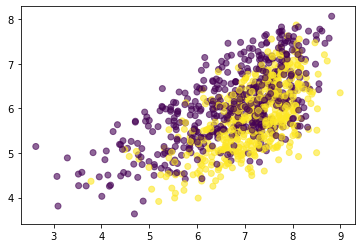

In [515]:
from matplotlib import pyplot as plt
i=2
L=genotype.loc[:,yeast_outlier_causal.loc[i,'pmarker']]
A=expression_data.loc[:,yeast_outlier_causal.loc[i,'cis']]
B=expression_data.loc[:,yeast_outlier_causal.loc[i,'gene']]
plt.scatter(A,B,c=L,alpha=0.6)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2dba32dcf8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2dba0552b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2dba32da90>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2dba0558d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2dba055ba8>],
 'means': []}

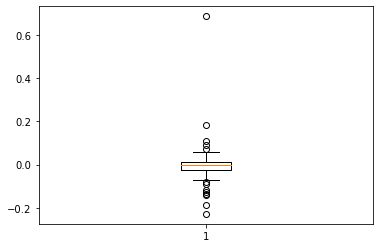

In [438]:
from matplotlib import pyplot as plt 
plt.boxplot(reqd['A_0']-reqd['A_1'])

(array([66.,  9.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([3.12938540e-04, 6.88194583e-02, 1.37325978e-01, 2.05832498e-01,
        2.74339018e-01, 3.42845537e-01, 4.11352057e-01, 4.79858577e-01,
        5.48365096e-01, 6.16871616e-01, 6.85378136e-01]),
 <BarContainer object of 10 artists>)

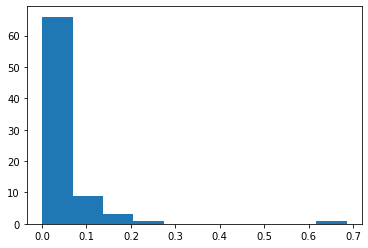

In [439]:
plt.hist(abs((reqd['A_0']-reqd['A_1'])))

In [441]:
sum(abs((reqd['A_0']-reqd['A_1']))>0.5)


1

In [7]:

def  relabel_matrix(matrix, index_name_dict, full_gene_list):
    """ Function doc 
    
        Use dictionnary to relabel rows and columns of matrix.
        Intended to be used for instance with genes.
        
        Input:
            matrix:     (regulatory) matrix with row and column labels of genes or transcription factors (TF). 
            index_name_dict:    dictionnary to map TF names to gene names (obtained from ensembl library).
        
        Output:
            sub_matrix: a submatrix of the input matrix, that contains 
                        the rows and columns with labels
                        that are compatible with the index_name_dict.
    """
    old_cols = matrix.columns
    old_rows = matrix.index.values
    print('old_cols, n=',len(old_cols) )
    print(old_cols)
    print('old_rows, n=', len(old_rows))
    print(old_rows)
    print('#  parsing columns:')
    col_subset, new_cols_dict = select_compatible_labels(old_cols, index_name_dict, full_gene_list)
    print('#  parsing rows:')
    row_subset, new_rows_dict = select_compatible_labels(old_rows, index_name_dict, full_gene_list)
    sub_matrix = matrix.loc[ row_subset, col_subset ]
    sub_matrix.rename( columns = new_cols_dict, inplace=True)
    sub_matrix.rename( index = new_rows_dict, inplace=True)
    print('  number of compatible columns',len(col_subset))
    print('  number of compatible rows',len(row_subset))
    return sub_matrix


def  select_compatible_labels( old_labels, label_dict, full_label_list ):
    """ Function doc 
    
        Parse all old_labels to find those compatible with the label_dict.
        Incompatible labels are printed in output for logging.
        
        Input: 
            old_labels:     labels of row or column.
            label_dict:     dictionnary to map TF names to gene names (obtained from ensembl library).
    
        Output:
            label_subset:   subset of compatible labels.
            new_labels_dict:    dictionnary of compatible TF names to gene names.
    """
    label_subset=[]
    new_labels_dict={}
    
    for la in  old_labels:
        # The below line tested if the dash character was causing labels to be misclassified.
        li=la.replace(',','%2')
        
        label_x = li.upper()
        if li[-1]=='p':
            #   Note: this is for transcription factors (TF) from yeastract, which end in letter p.
            upper_li=li[:-1]
            label_x = upper_li.upper()
            
        if label_x in label_dict.keys() :
            label_subset.append( li )
            new_labels_dict[li] = label_dict[ label_x]
        
        elif label_x in full_label_list :
            label_subset.append( li )
            new_labels_dict[li] = label_x
            
        else:
            #   print output for log.
            print(' This label is incompatible:', li)            
    return label_subset, new_labels_dict
    